# run grid search for both datasets

In [34]:
%%capture
!python assets/songbird-helper.py\
    --input-biom ../data/microbiome-cleaned.biom\
    --metadata-file ../data/microbiome-cleaned.tsv\
    --pseudo-model-formula '1'\
    --formula 'C(Pain_50_improvement, Treatment("no_response")) * C(timepoint_verbose, Treatment("day-14"))'\
    --out-dir ../results/songbird/songbird-grid/microbe

In [25]:
%%capture
!python assets/songbird-helper-metabolites.py\
    --input-biom ../data/metabolite-cleaned.biom\
    --metadata-file ../data/metabolite-cleaned.tsv\
    --pseudo-model-formula '1'\
    --formula 'C(ATTRIBUTE_Pain_50, Treatment("no_response")) * C(ATTRIBUTE_Time, Treatment("day-14"))'\
    --out-dir ../results/songbird/songbird-grid/metabolite

In [116]:
%%capture
!python assets/songbird-helper-plasma-metabolites.py\
    --input-biom ../data/plasma-metabolite-cleaned.biom\
    --metadata-file ../data/plasma-metabolite-cleaned.tsv\
    --pseudo-model-formula '1 '\
    --formula 'C(ATTRIBUTE_Pain_50, Treatment("no_response")) * C(ATTRIBUTE_Time, Treatment("day-14"))'\
    --out-dir ../results/songbird/songbird-grid/plasma-metabolite


## find best results (if a grid search is used)

In [26]:
import glob
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import os
import shutil
import subprocess
import qiime2 as q2
import pandas as pd
from biom import Table, load_table
from biom.util import biom_open

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

plt.style.use('ggplot')
%matplotlib inline


Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


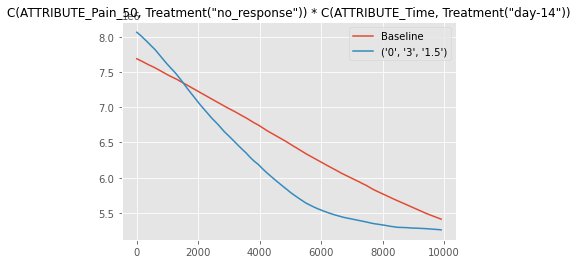

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


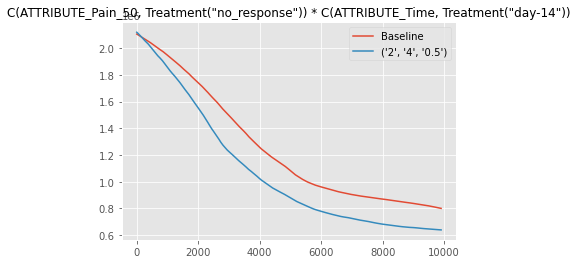

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


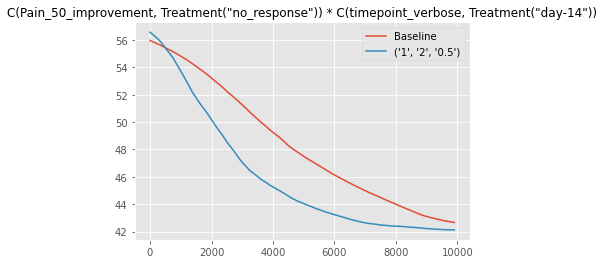

In [27]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

#%%capture
# for each body site repeat 
all_grid_results = {}
input_path = '../results'
intervals = ["microbe", "metabolite", "plasma-metabolite"]
# get all body site path(s)
partition_path = os.path.join(input_path, 'songbird/*')
body_sites = [bs_.split('/')[-1]
                  for bs_ in glob.glob(partition_path)]
# run for each body site
for body_site_ in body_sites:
    # for body site subsets
    sub_path = os.path.join(input_path, 'songbird', body_site_, '*')
    life_stages = [bs_.split('/')[-1]
                   for bs_ in glob.glob(sub_path)]   
    for life_stage_ in life_stages:
        # get all baseline models CV
        baseline_ls_path =  os.path.join(input_path, 'songbird',
                                         body_site_, life_stage_, '1*')
        baseline_models = glob.glob(baseline_ls_path)
        baseline_models = {tuple(id_.split('/')[-1].split('-')[1:]):id_
                           for id_ in baseline_models}
        # retrieve all baseline models
        for id_, path_ in baseline_models.items():
            # get path to data
            event_acc = EventAccumulator(path_)
            event_acc.Reload()
            # get scalar perams
            w_times, step_nums, vals = zip(*event_acc.Scalars('accuracy/cv_error'))
            baseline_models[id_] = [w_times, step_nums, vals]
        # get all fomrula based models CV
        all_ls_path =  os.path.join(input_path, 'songbird',
                                    body_site_, life_stage_, '*')
        formula_models = glob.glob(all_ls_path)
        exclude_ = glob.glob(baseline_ls_path)
        formula_models = sorted(set(formula_models) - set(exclude_))
        formula_models = {tuple(id_.split('/')[-1].split('-')[:]):id_
                           for id_ in formula_models}
        formula_models = {('-'.join(k[:-3]),k[-3],k[-2],k[-1]):v
                          for k,v in formula_models.items()}
        for id_, path_ in formula_models.items():
            # get path to data
            event_acc = EventAccumulator(path_)
            event_acc.Reload()
            # get scalar perams
            w_times, step_nums, vals = zip(*event_acc.Scalars('accuracy/cv_error'))
            # plot values
            plt.plot(moving_average(baseline_models[id_[1:]][-1], 100), label='Baseline')
            plt.plot(moving_average(vals, 100), label=id_[1:])
            plt.legend()
            plt.title(id_[0].replace('+','+\n'), fontsize=12)
            plt.show()
            # calc q^2-value
            #base_cv = np.mean(baseline_models[id_[1:]][-1][-10:])
            #form_cv = np.mean(vals[-10:])
            base_cv = np.mean(moving_average(baseline_models[id_[1:]][-1], 10)[-10:])
            form_cv = np.mean(moving_average(vals, 10)[-10:])
            q_squared = 1 - form_cv/base_cv
            formula_models[id_] = [form_cv, base_cv, q_squared]
        # make dataframe to save
        gird_results = pd.DataFrame(formula_models).T.reset_index()
        gird_results.columns = ['formula', 'min_features', 'batch_size',
                                'differential_prior', 'CV', 'baseline_CV',
                                'q_squared']
        # check to see if one time split or multiple
        if not any([ls in life_stage_ for ls in intervals]):
            life_stage_ = 'all'
        # save for bodysite
        all_grid_results[(body_site_, life_stage_)] = gird_results


In [28]:
# get best
all_grid_df = pd.concat(all_grid_results).reset_index().drop('level_2', axis=1)
all_grid_df = all_grid_df.rename({'level_0':'body_site','level_1':'life_stage'}, axis=1)
all_grid_df_allowed = all_grid_df[all_grid_df.q_squared > -1].copy()
ind_ = all_grid_df_allowed.groupby(['body_site','life_stage','formula'])[['CV']].idxmin().values
all_grid_df_best = all_grid_df_allowed.loc[ind_.flatten(), :]
all_grid_df_best


,body_site,life_stage,formula,min_features,batch_size,differential_prior,CV,baseline_CV,q_squared
0,songbird-grid,metabolite,"C(ATTRIBUTE_Pain_50, Treatment(""no_response""))...",0,3,1.5,5.256087e+06,5.404103e+06,0.027390
2,songbird-grid,microbe,"C(Pain_50_improvement, Treatment(""no_response""...",1,2,0.5,4.212159e+01,4.265295e+01,0.012458
1,songbird-grid,plasma-metabolite,"C(ATTRIBUTE_Pain_50, Treatment(""no_response""))...",2,4,0.5,6.386206e+05,7.981173e+05,0.199841
